In [191]:
import math
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [192]:
#Função Sphere
def sphere(vetor, limite_inferior=-100, limite_superior=100):
  resultado = 0
  
  for i in vetor:
    resultado += i**2
  
  return resultado

#Função rastrigin
def rastrigin(vetor, limite_inferior=-30, limite_superior=30):
  resultado = 0
  
  for i in vetor:
    x = 2*math.pi*i
    resultado += 10 + ((i**2) - 10 * math.cos(x))
    

  return resultado 

#Função rosenbrock
def rosenbrock(vetor, limite_inferior=-5.12, limite_superior=5.12):
  resultado = 0
  
  for i in range(0,(len(vetor)-1)):
    resultado += 100*(vetor[i+1] - vetor[i]**2)**2 + (vetor[i] - 1)**2
    
  return resultado

In [193]:
# E se no cálculo de posição para a abelha, o valor sair dos limites do espaço de busca?

class AlgoritmoColoniaAbelhas:
    def __init__(self, funcao, limite_inferior, limite_superior, qtd_ciclos, tamanho_colonia, dimensao, fator_abandono):
        self.funcao = funcao
        self.limite_inferior = limite_inferior
        self.limite_superior = limite_superior
        self.qtd_ciclos = qtd_ciclos
        self.tamanho_colonia = tamanho_colonia
        self.dimensao = dimensao
        self.fator_abandono = fator_abandono
        self.fontes_alimentacao = np.random.uniform(low=limite_inferior, high=limite_superior, size=(tamanho_colonia//2, dimensao))
        self.abelhas_empregadas = []
        self.abelhas_observadoras = []
        self.tentativas = np.zeros(tamanho_colonia//2)
        self.historico_fitness = []
        self.melhor_global = float('inf')
        self.melhor_fonte_global = None


    def calcular_fitness_fontes(self):
        return np.array([self.funcao(fonte) for fonte in self.fontes_alimentacao])

    def calcular_fitness(self, vetor):
        return self.funcao(vetor)
    
    def realizar_ciclo(self):
        for ciclo in range(self.qtd_ciclos):
            self.atribuir_posicao_empregadas(ciclo)
            self.atribuir_posicao_observadoras(self.calcular_fitness_fontes())
            self.atribuir_posicao_exploradoras()
            fitness_atual = self.calcular_fitness_fontes()
            melhor_fitness_iteracao = np.min(fitness_atual)
            indice_melhor_fitness = np.argmin(fitness_atual)
            if melhor_fitness_iteracao < self.melhor_global:
                self.melhor_global = melhor_fitness_iteracao
                self.melhor_fonte_global = self.fontes_alimentacao[indice_melhor_fitness].copy()
            self.historico_fitness.append(melhor_fitness_iteracao)
            if ciclo == 0 or ciclo == self.qtd_ciclos - 1:
                print(f"Geração {ciclo+1} | Melhor solução: {self.melhor_fonte_global} | Fitness: {np.min(self.historico_fitness)} | Histórico Fitness: {self.historico_fitness}")
            
    def atribuir_posicao_empregadas(self, numero_ciclo):
        if numero_ciclo == 0:
            self.abelhas_empregadas = self.fontes_alimentacao
        self.abelhas_empregadas = self.atualizar_posicao(self.abelhas_empregadas)

    def atribuir_posicao_observadoras(self, fitness):
        total_fitness_invertido = np.sum([1 / fitness[i] for i in range(self.tamanho_colonia // 2)])
        proporcoes_fitness = []
        self.abelhas_observadoras = [] # Eu sempre tenho que começar assim? Ou seja, ela não se baseia na posição do ciclo passado. Sempre começa vazia.
        for i in range(self.tamanho_colonia // 2):
            proporcoes_fitness.append(1 / fitness[i] / total_fitness_invertido)
        for i in range(self.tamanho_colonia // 2):
            probabilidade_random = np.random.rand()
            probabilidade_acumulativa = 0
            for posicao_abelha, proporcao in zip(self.fontes_alimentacao, proporcoes_fitness):
                probabilidade_acumulativa += proporcao
                if probabilidade_random <= probabilidade_acumulativa:
                    self.abelhas_observadoras.append(posicao_abelha)
                    break
        self.abelhas_observadoras = self.atualizar_posicao(self.abelhas_observadoras)

    def atribuir_posicao_exploradoras(self):
        for i in range(len(self.abelhas_empregadas)):
            if self.tentativas[i] > self.fator_abandono:
                self.fontes_alimentacao[i] = np.random.uniform(low=self.limite_inferior, high=self.limite_superior, size=self.dimensao)
                self.abelhas_empregadas[i] = self.fontes_alimentacao[i]
                self.tentativas[i] = 0

    def atualizar_posicao(self, abelhas):
        for i in range(len(abelhas)):
            posicao_calculada = self.calcular_posicao(i)
            if self.calcular_fitness(posicao_calculada) < self.calcular_fitness(abelhas[i]):
                abelhas[i] = posicao_calculada
                self.fontes_alimentacao[i] = posicao_calculada
                self.tentativas[i] = 0
            else:
                self.tentativas[i] += 1
        return abelhas
    
    def calcular_posicao(self, indice_fonte):
        fonte = self.fontes_alimentacao[indice_fonte]
        rand_i = np.random.randint(low=0, high=len(fonte))
        rand_k = np.random.randint(low=0, high=len(self.fontes_alimentacao))
        while indice_fonte != rand_k:
            rand_k = np.random.randint(low=0, high=len(self.fontes_alimentacao))
        fonte_aleatoria = self.fontes_alimentacao[rand_k]
        rand_phi = np.random.randint(low=-1, high=2)
        valor_nova_posicao = fonte[rand_i] + rand_phi * (fonte[rand_i] - fonte_aleatoria[rand_i])
        fonte[rand_i] = valor_nova_posicao
        return fonte

    
    def plotar_grafico_convergencia(self): 
        valores_x = list(range(self.qtd_ciclos))
        plt.figure(figsize=(10, 6))
        plt.plot(valores_x, self.historico_fitness, marker='o', linestyle='-', color='b', label='Fitness')
        plt.xlabel('Ciclo')
        plt.ylabel('Melhor Fitness')
        plt.title('Melhor Fitness vs. Ciclo')
        plt.grid(True)
        plt.legend()
        plt.show()

Geração 1 | Melhor solução: [-42.95884308 -31.92391633  71.49338513 -13.18252551 -27.34089066
 -55.53461109  18.63304024  51.06100309 -22.17778875  67.79460201] | Fitness: 20023.677661524573 | Histórico Fitness: [20023.677661524573]
Geração 30 | Melhor solução: [ 22.43189179 -31.43222788   6.59243299 -54.74446567  34.77099043
   2.81922486 -19.83183865 -33.43523799  32.1189461  -76.04557006] | Fitness: 14074.333604463585 | Histórico Fitness: [20023.677661524573, 20023.677661524573, 20023.677661524573, 20023.677661524573, 20023.677661524573, 20023.677661524573, 20023.677661524573, 20023.677661524573, 20023.677661524573, 18440.354112294975, 18440.354112294975, 18440.354112294975, 18440.354112294975, 18440.354112294975, 18440.354112294975, 18440.354112294975, 18440.354112294975, 18440.354112294975, 18440.354112294975, 14074.333604463585, 14074.333604463585, 14074.333604463585, 14074.333604463585, 14074.333604463585, 14074.333604463585, 14074.333604463585, 14074.333604463585, 14074.3336044

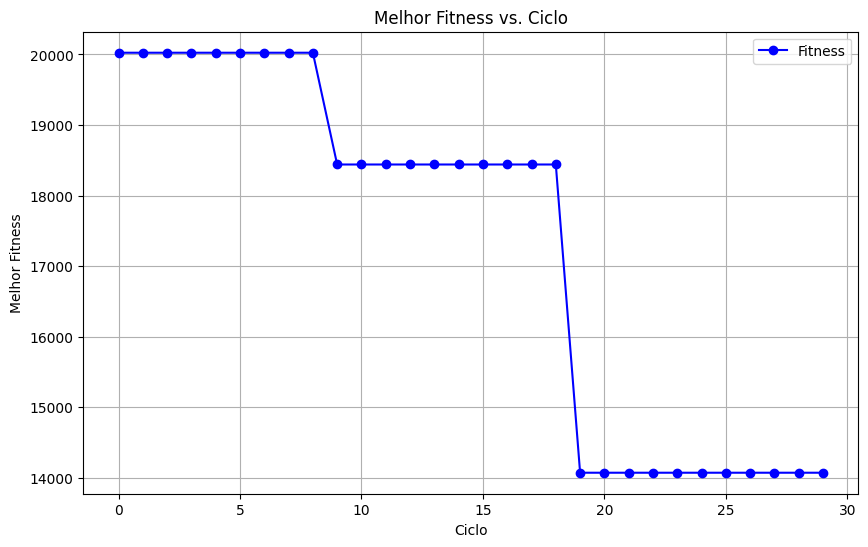

In [194]:
aca0 = AlgoritmoColoniaAbelhas(funcao=sphere, limite_inferior=-100, limite_superior=100, qtd_ciclos=30, tamanho_colonia=30, dimensao=10, fator_abandono=5)
aca0.realizar_ciclo()
aca0.plotar_grafico_convergencia()

In [196]:
'''
for i in range(len(self.fontes_alimentacao)):
            posicao_calculada = self.calcular_posicao(i)
            if self.calcular_fitness(posicao_calculada) < self.calcular_fitness(self.abelhas_empregadas[i]):
                self.abelhas_empregadas[i] = posicao_calculada
                self.fontes_alimentacao = posicao_calculada
                self.tentativas[i] = 0
            else:
                self.tentativas[i] += 1
'''
aca0.calcular_fitness([ 22.43189179, -31.43222788,   6.59243299, -54.74446567,  34.77099043,
   2.81922486, -19.83183865, -33.43523799,  32.1189461,  -76.04557006])

14074.333605307009